In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Optional

In [22]:
# Helpers for merging entries

def merge_close_entries(df, time_delta):
    # Use a sliding window to merge close entries, assuming df is sorted by cat, tid, ts
    i = 0

    while i < len(df) - 1:
        curr_end = df.loc[i, 'ts'] + df.loc[i, 'dur']
        next_start = df.loc[i + 1, 'ts']
        next_end = df.loc[i + 1, 'ts'] + df.loc[i + 1, 'dur']

        if comparable(df.loc[i], df.loc[i + 1]) and next_start <= curr_end + time_delta:
            df.loc[i, 'dur'] = max(curr_end, next_end) - df.loc[i, 'ts']
            # Drop the merged row and reset index
            df.drop(i + 1, inplace=True)
            df.reset_index(drop=True, inplace=True)
        else:
            # If no merge happens, move to the next row
            i += 1 

    return df

def comparable(a, b):
    return a['cat'] == b['cat'] and a['tid'] == b['tid']

# Helpers for smoothing curves
def moving_average(data, window_size):
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='same')

from scipy.ndimage import gaussian_filter1d

In [23]:
TIME_DELTA = 500_000  # 500ms

def process_df(
    df: pd.DataFrame,
    time_delta: int = TIME_DELTA,
    sampling_rate: int = 1,
    smooth: Optional[str] = None,
    window_size: Optional[int] = None,
    sigma: Optional[int] = None,
):
    # Sort by cat, tid, ts and merge close entries
    df = df.sort_values(by=["cat", "tid", "ts"]).reset_index(drop=True)
    len_before = len(df)
    df = merge_close_entries(df, time_delta)
    len_after = len(df)

    print("Length before: {}, after: {}".format(len_before, len_after))

    # Convert to seconds
    df["ts"] = (df["ts"] - df["ts"].min()) / 1e6
    df["dur"] = df["dur"] / 1e6

    ticks = np.arange(0, 175, sampling_rate)

    # Record parallelism of each task
    consume = np.zeros(len(ticks))
    produce = np.zeros(len(ticks))
    inference = np.zeros(len(ticks))

    for idx, i in enumerate(ticks):
        temp_df = df.copy()
        temp_df = temp_df[(temp_df["ts"] <= i) & (i <= temp_df["ts"] + temp_df["dur"])]
        consume[idx] = len(temp_df[temp_df["cat"] == "task::MapBatches(consume)"])
        produce[idx] = len(temp_df[temp_df["cat"] == "task::ReadRange->MapBatches(produce)"])
        inference[idx] = len(temp_df[temp_df["cat"] == "task::MapBatches(inference)"])

    # Smooth the output
    assert smooth == "moving_average" or smooth == "gaussian" or smooth is None
    if smooth == "moving_average":
        consume = moving_average(consume, window_size)
        produce = moving_average(produce, window_size)
    elif smooth == "gaussian":
        consume = gaussian_filter1d(consume, sigma)
        produce = gaussian_filter1d(produce, sigma)

    return ticks, consume, produce, inference

Length before: 1680, after: 435
Length before: 1680, after: 466


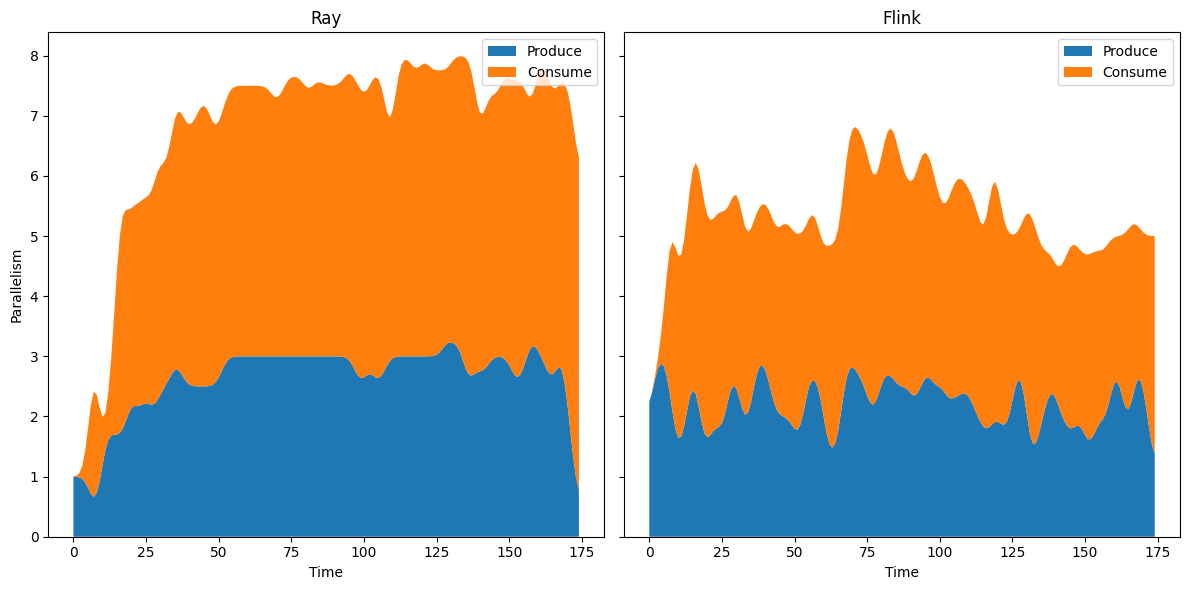

In [30]:
SAMPLE_EVERY = 1 # seconds
SMOOTH = 'gaussian'
WINDOW_SIZE = (
    10  # Specify window_size if using moving average smoothing, sigma if using gaussian smoothing
)
SIGMA = 2

df_ray = pd.read_json("./timeline_ray_three_stage.json")
df_flink = pd.read_json("./timeline_flink_three_stage.json")

ticks_ray, consume_ray, produce_ray, inference_ray = process_df(
    df_ray, sampling_rate=SAMPLE_EVERY, smooth=SMOOTH, window_size=WINDOW_SIZE, sigma=SIGMA
)
ticks_flink, consume_flink, produce_flink, inference_flink = process_df(
    df_flink, sampling_rate=SAMPLE_EVERY, smooth=SMOOTH, window_size=WINDOW_SIZE, sigma=SIGMA
)


fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axs[0].stackplot(ticks_ray, produce_ray, consume_ray, labels=[ "Produce", "Consume"])
axs[0].set_title("Ray")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Parallelism")
axs[0].legend()

axs[1].stackplot(ticks_flink, produce_flink, consume_flink, labels=[ "Produce", "Consume"])
axs[1].set_title("Flink")
axs[1].set_xlabel("Time")
axs[1].legend()

plt.tight_layout()
plt.show()

In [2]:
df = pd.read_json("./timeline_flink_three_stage.json")
df = df.sort_values(by=['cat', 'tid', 'ts']).reset_index(drop=True)
print(len(df))
df.head()

1680


,cat,name,pid,tid,ts,dur,ph,cname,args
0,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,1.721162e+15,826333.272,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
1,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,1.721162e+15,837706.816,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
2,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,1.721162e+15,787587.293,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
3,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,1.721162e+15,741823.692,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
4,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,1.721162e+15,1079201.337,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...


In [3]:
TIME_DELTA = 500_000 # 500ms

df = merge_close_entries(df, TIME_DELTA)
print(len(df))

466


In [4]:
df.to_json("./timeline_flink_three_stage_merged.json", orient='records')


In [5]:
df['ts'] = (df['ts'] - df['ts'].min()) / 1e6
df['dur'] = df['dur'] / 1e6
df.head()

,cat,name,pid,tid,ts,dur,ph,cname,args
0,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,33.692348,0.826333,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
1,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,41.456410,5.347418,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
2,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,60.363393,4.611914,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
3,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,71.130070,2.935625,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
4,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.47.143,CPU: 0,74.608972,1.097825,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...


In [6]:
df['cat'].value_counts()

cat
task::MapBatches(consume)               208
task::MapBatches(inference)             182
task::ReadRange->MapBatches(produce)     76
Name: count, dtype: int64

In [10]:
ticks = np.arange(0, 175, 0.1)

consume = np.zeros(len(ticks))
produce = np.zeros(len(ticks))
inference = np.zeros(len(ticks))

for idx, i in enumerate(ticks):
    temp_df = df.copy()
    temp_df = temp_df[(temp_df['ts'] <= i) & (i <= temp_df['ts'] + temp_df['dur'])]
    consume[idx] = len(temp_df[temp_df['cat'] == 'task::MapBatches(consume)'])
    produce[idx] = len(temp_df[temp_df['cat'] == 'task::ReadRange->MapBatches(produce)'])
    inference[idx] = len(temp_df[temp_df['cat'] == 'task::MapBatches(inference)'])


In [15]:
# def moving_average(data, window_size):
#     """Compute the moving average using a simple sliding window approach."""
#     kernel = np.ones(window_size) / window_size
#     return np.convolve(data, kernel, mode='same')

# window_size = 20
# consume_copy = moving_average(consume, window_size)
# produce_copy = moving_average(produce, window_size)

from scipy.ndimage import gaussian_filter1d

sigma = 10
consume_copy = gaussian_filter1d(consume, sigma=sigma)
produce_copy = gaussian_filter1d(produce, sigma=sigma)

# consume_copy = consume
# produce_copy = produce

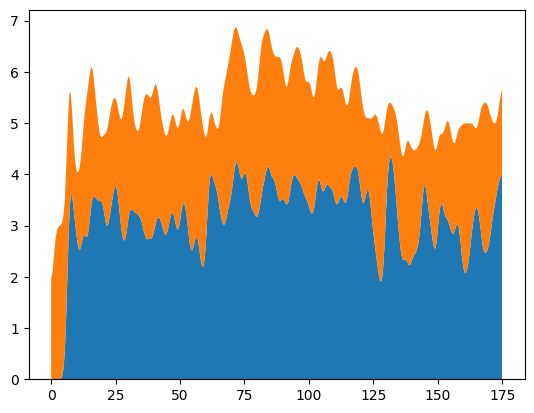

In [17]:
plt.stackplot(ticks, produce_copy, consume_copy)

In [12]:
df['cat'].value_counts()

cat
task::MapBatches(consume)               206
task::MapBatches(inference)             154
task::ReadRange->MapBatches(produce)     75
Name: count, dtype: int64